# Correlations


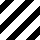
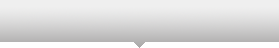
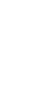
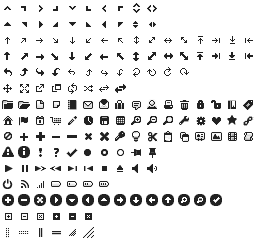
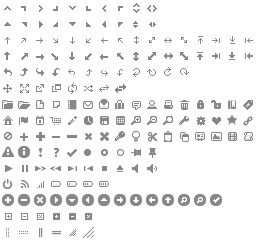
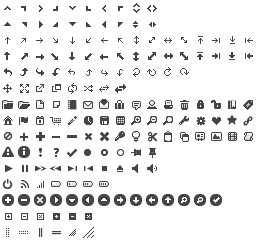
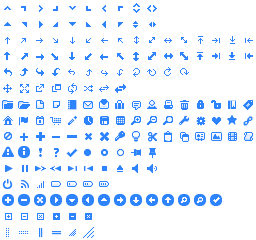
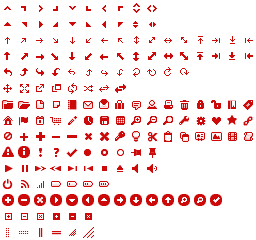
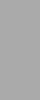
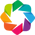
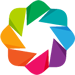
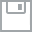
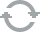
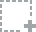
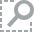
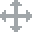
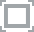
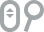


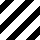
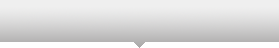
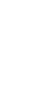
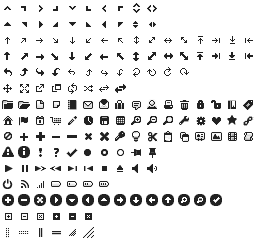
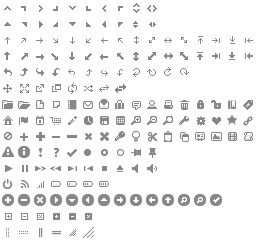
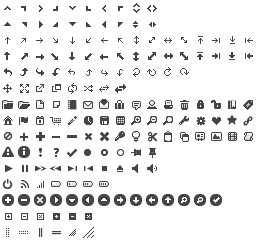
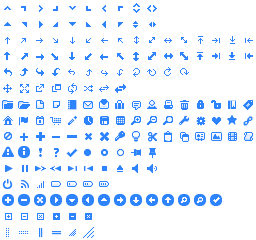
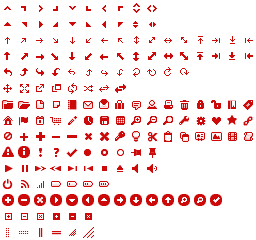
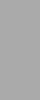
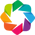
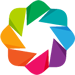
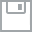
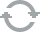
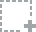
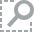
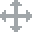
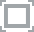
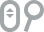

In [1]:
from IPython.display import display, HTML
from charts.correlation_plots import correlation_plot  # my package, could be downloaded from https://github.com/alfiya400/charts.git
import cPickle
corr = cPickle.load(open("data/corr_matrix.pkl"))
correlation_plot(corr, "plots/correlations.html")
display(HTML(filename="plots/correlations.html"))

# Distribution plots by feature

Populating the interactive namespace from numpy and matplotlib


/Applications/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


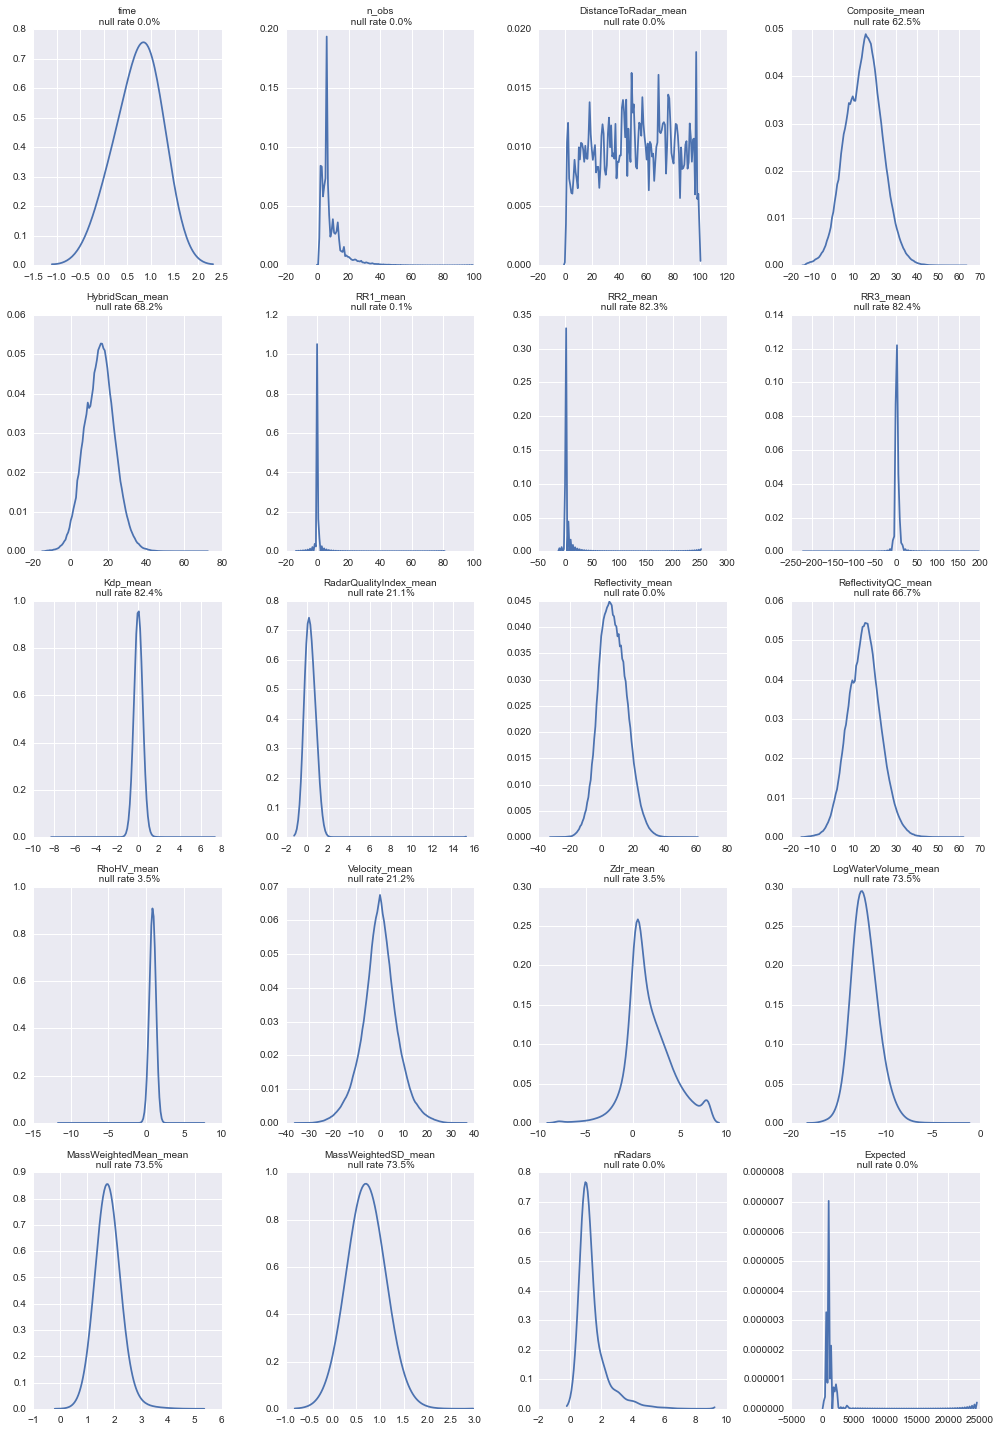

In [2]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import re
from pandas.tools.plotting import andrews_curves
import seaborn as sns
sns.set()

# DISTR PLOT
data = pd.read_csv("data/train_preprocessed.csv")
Id = data["Id"].copy()
data.drop("Id", axis=1, inplace=True)

# select only mean aggregation for each feature
plt_cols = [_ for _ in data.columns.values if (_ in ["n_obs", "time", "nRadars", "Expected"] 
                or re.findall("_mean", _))]
data = data[plt_cols]

n_plots = len(plt_cols)
n_cols = 4
n_rows = (n_plots + n_cols - 1) / n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize = (3.5 * n_cols, 4 * n_rows))

for ax, col in zip(axs.flat, plt_cols):
    ax.set_title("{0}\n null rate {1:.1f}%".format(col, pd.isnull(data[col]).sum()*100./data[col].size), {"fontsize":10})
    sns.kdeplot(data[col], ax=ax, label="", bw=0.4)
fig.tight_layout()

# plt.savefig("plots/distributions.png", format="png")

# Cluster analysis

From Andrews curves we could see that there are 2 clusters and they are perfectly found by KMeans clustering algorithm

Also distribution of rain volume is different in each cluster, so I may suggest that fitting different models for each cluster may increase the score

count    mean     std  min  25%  50%  75%  max
Cluster                                                 
0        928563  0.4020  4.7384    0    0    0    0   70
1        198131  1.9085  7.4495    0    0    0    1   70

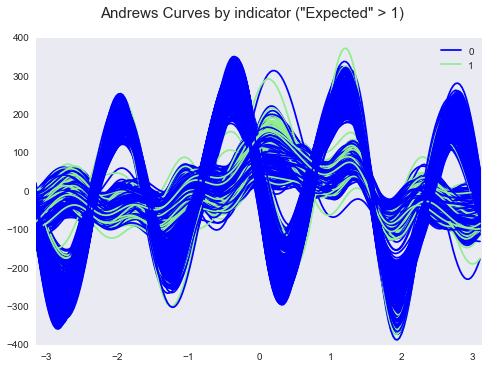

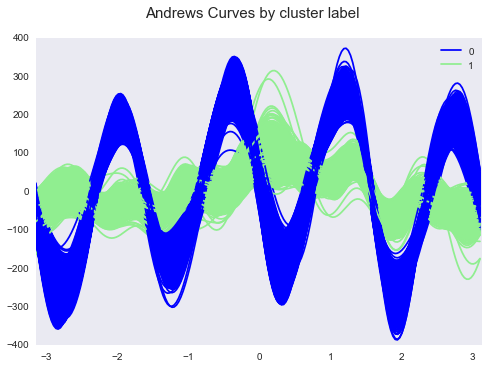

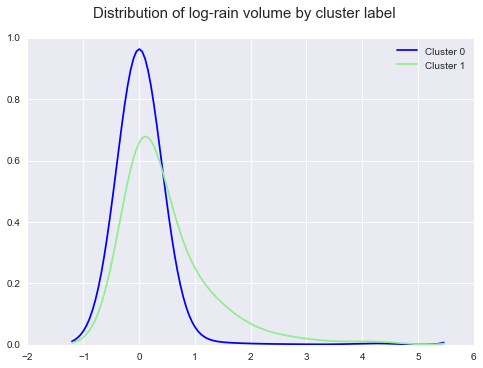

In [61]:
data = pd.read_csv("data/train_preprocessed.csv")
Id = data["Id"].copy()
data.drop("Id", axis=1, inplace=True)

# select only mean aggregation for each feature
plt_cols = [_ for _ in data.columns.values if (_ in ["n_obs", "time", "nRadars", "Expected"] 
                or re.findall("_mean", _))]
data = data[plt_cols]

expected = data["Expected"].copy()
expected[expected.values > 70] = 70
data.drop("Expected", axis=1, inplace=True)

plt_cols.remove("Expected")
data = data.fillna(np.min(data) - (np.max(data)-np.min(data))/float(data.shape[0]))

clusters = 2
kmeans = KMeans(n_clusters=clusters)
data["Cluster"] = kmeans.fit_predict(data.values)

display(HTML("<h2><b>Rain volume statistics by cluster</b></h2>"))
display(np.round(expected.groupby(data["Cluster"]).describe(), 4).unstack())

randomState = np.random.RandomState(15)
idx = randomState.choice(a=np.where(data["Cluster"].values > -1)[0], size=5000, replace=False)

tmp = data.drop("Cluster", axis=1).iloc[idx,]
tmp["Expected"] = (expected[idx] > 1).astype(int)

fig = plt.figure()
fig.suptitle('Andrews Curves by indicator ("Expected" > 1)', fontsize=15)
andrews_curves(tmp, "Expected", color=['blue', 'lightgreen'])

fig = plt.figure()
fig.suptitle('Andrews Curves by cluster label', fontsize=15)
andrews_curves(data.iloc[idx,], "Cluster", color=['blue', 'lightgreen'])

fig=plt.figure()
fig.suptitle('Distribution of log-rain volume by cluster label', fontsize=15)
ax=fig.gca()
ax.set_xlim(-2, 6)
sns.kdeplot(np.log(1 + expected[data["Cluster"].values == 0]), ax=ax, label="Cluster 0", bw=0.4, color='blue')
sns.kdeplot(np.log(1 + expected[data["Cluster"].values == 1]), ax=ax, label="Cluster 1", bw=0.4, color='lightgreen')
